# Regression 101

This notebook introduces gently the concept of regression and how to perform it in Python. The essential package is sklearn, containing a plethophora of useful functions for machine learning.

Load packages

In [56]:
from ucimlrepo import fetch_ucirepo # repo with datasets
import numpy as np # repo for numeric goodies
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.feature_selection import RFE # Recursive Feature Elimination 
import statsmodels.api as sm # alternative library for modeling, which focuses more on statistics
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Select a dataset to experiment with. For linear regression, we will look at soybean yield. The soybean dataset is hosted on [ucimlrepo](https://archive.ics.uci.edu/dataset/913/forty+soybean+cultivars+from+subsequent+harvests)

In [4]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
forty_soybean_cultivars_from_subsequent_harvests = fetch_ucirepo(id=913) 
  
# data (as pandas dataframes) 
X = forty_soybean_cultivars_from_subsequent_harvests.data.features 
y = forty_soybean_cultivars_from_subsequent_harvests.data.targets 
  
# metadata 
print(forty_soybean_cultivars_from_subsequent_harvests.metadata) 
  
# variable information 
print(forty_soybean_cultivars_from_subsequent_harvests.variables) 


{'uci_id': 913, 'name': 'Forty Soybean Cultivars from Subsequent Harvests', 'repository_url': 'https://archive.ics.uci.edu/dataset/913/forty+soybean+cultivars+from+subsequent+harvests', 'data_url': 'https://archive.ics.uci.edu/static/public/913/data.csv', 'abstract': 'Soybean cultivation is one of the most important because it is used in several segments of the food industry. The evaluation of soybean cultivars subject to different planting and harvesting characteristics is an ongoing field of research. We present a dataset obtained from forty soybean cultivars planted in subsequent seasons. The experiment used randomized blocks, arranged in a split-plot scheme, with four replications. The following variables were collected: plant height, insertion of the first pod, number of stems, number of legumes per plant, number of grains per pod, thousand seed weight, and grain yield, resulting in 320 data samples. The dataset presented can be used by researchers from different fields of activit

It is good practice to get an overview on the dataset first:

In [9]:
X.head()

,Season,Cultivar,Repetition,PH,IFP,NLP,NGP,NGL,NS,MHG,GY
0,1,NEO 760 CE,1,58.80,15.20,98.2,177.80,1.81,5.2,152.20,3232.82
1,1,NEO 760 CE,2,58.60,13.40,102.0,195.00,1.85,7.2,141.69,3517.36
2,1,NEO 760 CE,3,63.40,17.20,100.4,203.00,2.02,6.8,148.81,3391.46
3,1,NEO 760 CE,4,60.27,15.27,100.2,191.93,1.89,6.4,148.50,3312.58
4,1,MANU IPRO,1,81.20,18.00,98.8,173.00,1.75,7.4,145.59,3230.99


In [10]:
X.describe()

,Season,Repetition,PH,IFP,NLP,NGP,NGL,NS,MHG,GY
count,320.000000,320.000000,320.000000,320.0000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000
mean,1.500000,2.500000,68.386781,15.4650,59.088313,135.085844,2.290844,4.071656,168.322313,3418.553794
std,0.500783,1.119785,8.958194,3.0243,20.068187,60.494529,0.840116,1.474531,19.625566,503.003602
min,1.000000,1.000000,47.600000,7.2000,20.200000,47.800000,0.940000,0.400000,127.060000,1538.230000
25%,1.000000,1.750000,62.950000,13.6000,44.350000,95.052500,2.000000,3.000000,153.845000,3126.611552
50%,1.500000,2.500000,67.200000,15.6000,54.500000,123.000000,2.280000,3.800000,166.150000,3397.276724
75%,2.000000,3.250000,74.347500,17.3300,71.220000,161.350000,2.480000,5.000000,183.182500,3708.262931
max,2.000000,4.000000,94.800000,26.4000,123.000000,683.400000,14.860000,9.000000,216.000000,4930.000000


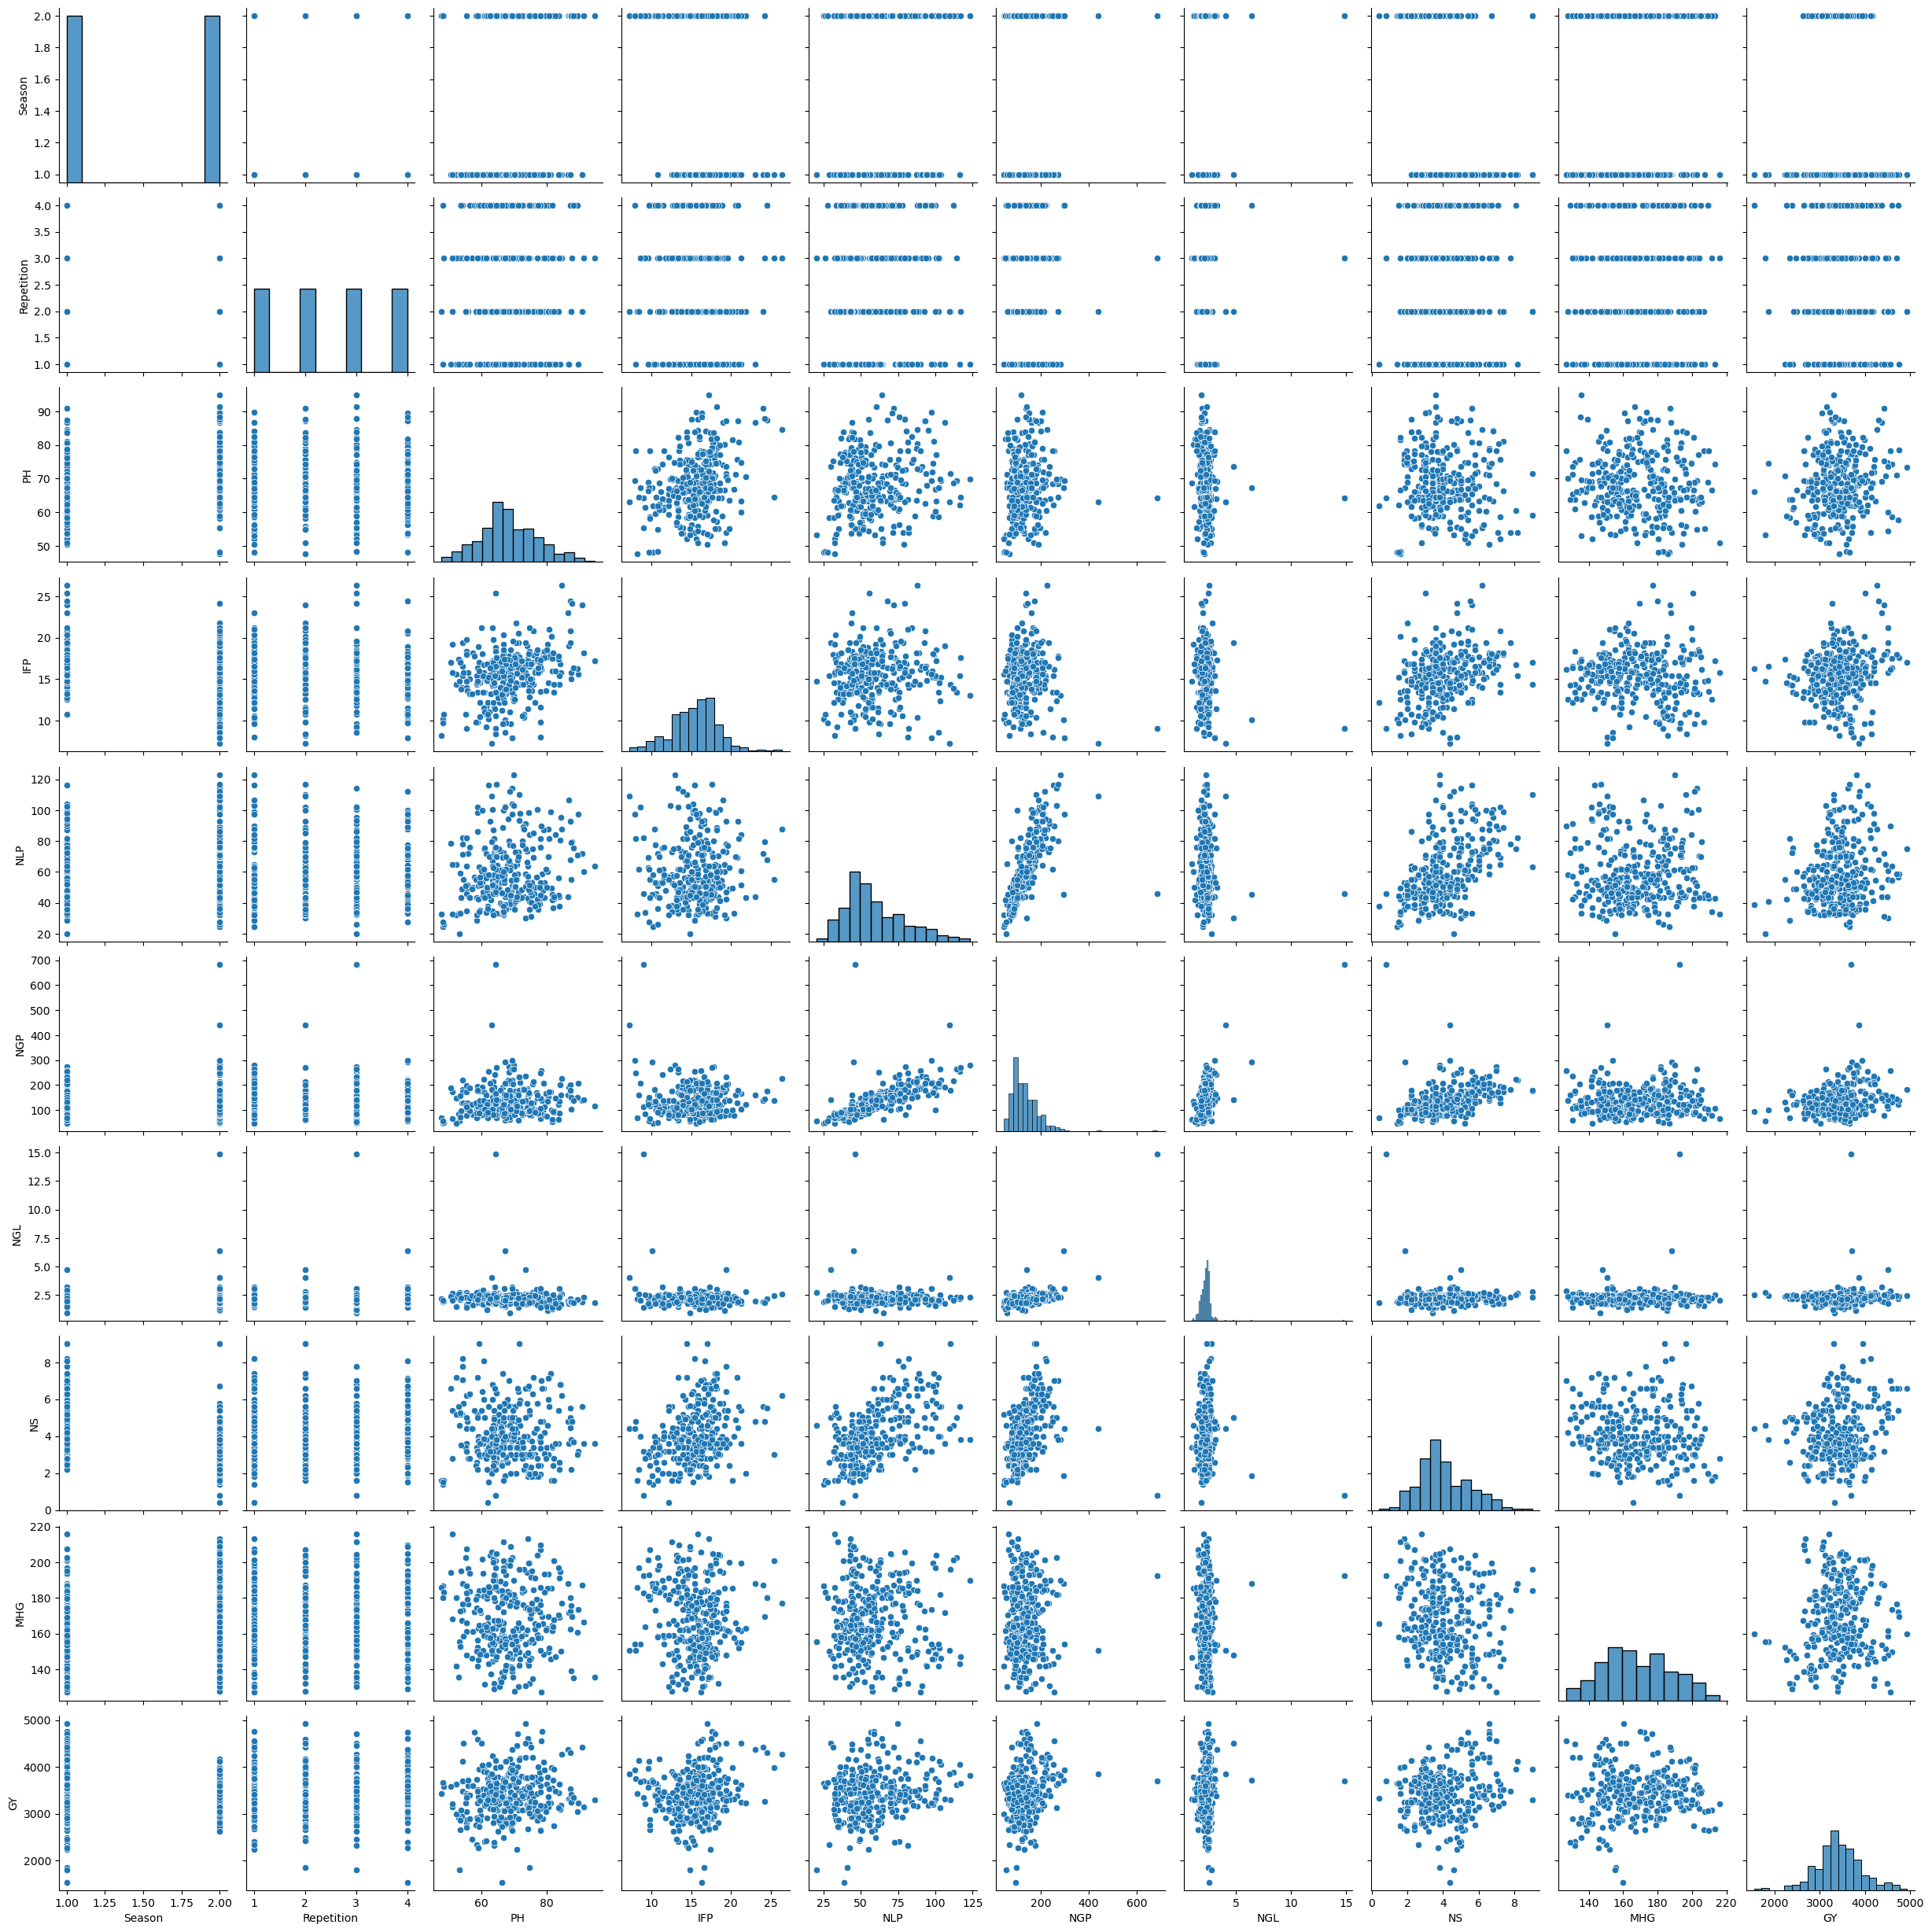

In [11]:
sns.pairplot(X)

In [14]:
# check for NaN values
X.isnull().any()

Season        False
Cultivar      False
Repetition    False
PH            False
IFP           False
NLP           False
NGP           False
NGL           False
NS            False
MHG           False
GY            False
dtype: bool

In [ ]:
# Look at the yield ('GY') of the different cultivars
X = X.sort_values(by='Cultivar')
plt.figure(figsize=(16, 6))
sns.boxplot(x='Cultivar', y='GY', data=X)
plt.xticks(rotation=90)
plt.title('GY by Cultivar')
plt.show()

In [ ]:
# check for correlations among the numeric variables
# Select only numeric columns
numeric_cols = X.select_dtypes(include='number').columns

X[numeric_cols].corr()

,Season,Repetition,PH,IFP,NLP,NGP,NGL,NS,MHG,GY
Season,1.000000e+00,1.725361e-16,0.268523,-0.337796,0.056059,-0.002469,-0.010543,-0.506016,0.307912,-0.019710
Repetition,1.725361e-16,1.000000e+00,0.001455,0.016847,0.000194,0.011717,0.015945,-0.006465,0.013688,-0.005697
PH,2.685229e-01,1.454702e-03,1.000000,0.325370,0.172737,0.063474,-0.081961,-0.048734,-0.046618,0.123281
IFP,-3.377963e-01,1.684695e-02,0.325370,1.000000,0.053085,-0.057423,-0.151598,0.344360,-0.071123,0.139090
NLP,5.605933e-02,1.939016e-04,0.172737,0.053085,1.000000,0.681794,-0.062122,0.521903,-0.000687,0.198741
NGP,-2.469477e-03,1.171739e-02,0.063474,-0.057423,0.681794,1.000000,0.621507,0.359697,0.032085,0.238883
NGL,-1.054330e-02,1.594473e-02,-0.081961,-0.151598,-0.062122,0.621507,1.000000,-0.073567,0.051604,0.077404
NS,-5.060156e-01,-6.464545e-03,-0.048734,0.344360,0.521903,0.359697,-0.073567,1.000000,-0.129252,0.167022
MHG,3.079121e-01,1.368809e-02,-0.046618,-0.071123,-0.000687,0.032085,0.051604,-0.129252,1.000000,0.074552
GY,-1.970989e-02,-5.696533e-03,0.123281,0.139090,0.198741,0.238883,0.077404,0.167022,0.074552,1.000000


<Axes: >

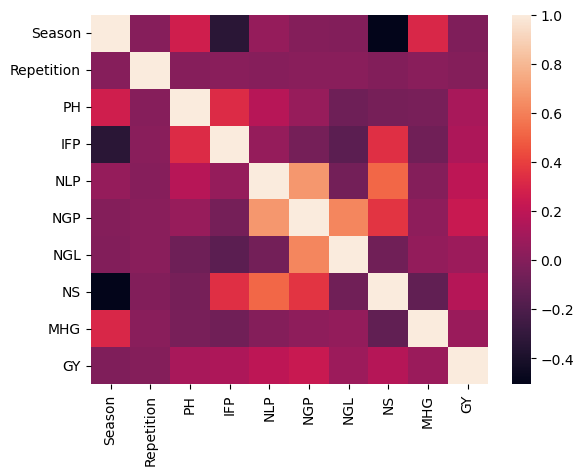

In [23]:
# ckeck out for correlations:
sns.heatmap(X[numeric_cols].corr())

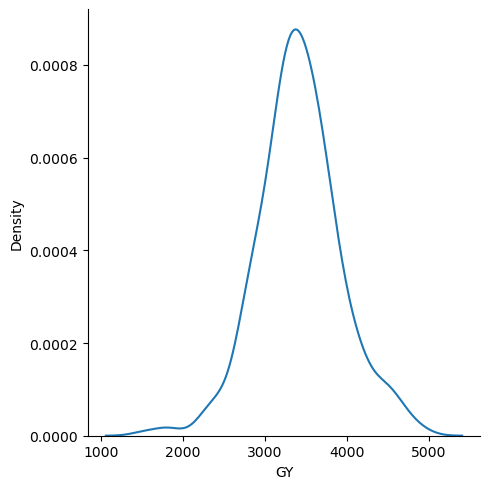

In [26]:
# check distribution of the target:
sns.displot(X['GY'], kind='kde')

## Prepare data for Regression

1) Encode categorical variables

2) generate your dataframe with independent variables to predict from

3) generate your array of the dependent variable (the one, you want to predict, here: yield)

4) split your data into test and train

In [ ]:
# One-hot encode the 'Cultivar ' column
X_encoded = pd.get_dummies(X, columns=['Cultivar']).astype(int)
print(X_encoded)


     Season  Repetition  PH  IFP  NLP  NGP  NGL  NS  MHG    GY  ...  \
0         1           1  58   15   98  177    1   5  152  3232  ...   
1         1           2  58   13  102  195    1   7  141  3517  ...   
2         1           3  63   17  100  203    2   6  148  3391  ...   
3         1           4  60   15  100  191    1   6  148  3312  ...   
4         1           1  81   18   98  173    1   7  145  3230  ...   
..      ...         ...  ..  ...  ...  ...  ...  ..  ...   ...  ...   
315       2           4  88   16   75  139    1   3  135  3348  ...   
316       2           1  64   16   76  168    2   3  145  3418  ...   
317       2           2  64   17  116  271    2   3  147  3651  ...   
318       2           3  58   14   86  180    2   2  156  3487  ...   
319       2           4  62   16   93  206    2   3  157  3605  ...   

     Cultivar_MONSOY M8606I2X  Cultivar_NEO 760 CE  Cultivar_NEO 790 IPRO  \
0                           0                    1                    

In [28]:
# create X and y for your model 
X_encoded.columns

Index(['Season', 'Repetition', 'PH', 'IFP', 'NLP', 'NGP', 'NGL', 'NS', 'MHG',
       'GY', 'Cultivar_74K75RSF CE', 'Cultivar_77HO111I2X - GUAPORÉ',
       'Cultivar_79I81RSF IPRO', 'Cultivar_82HO111 IPRO - HO COXIM IPRO',
       'Cultivar_82I78RSF IPRO', 'Cultivar_83IX84RSF I2X',
       'Cultivar_96R29 IPRO', 'Cultivar_97Y97 IPRO', 'Cultivar_98R30 CE',
       'Cultivar_ADAPTA LTT 8402 IPRO', 'Cultivar_ATAQUE I2X',
       'Cultivar_BRASMAX BÔNUS IPRO', 'Cultivar_BRASMAX OLIMPO IPRO',
       'Cultivar_ELISA IPRO', 'Cultivar_EXPANDE LTT 8301 IPRO',
       'Cultivar_FORTALECE L090183 RR', 'Cultivar_FORTALEZA IPRO',
       'Cultivar_FTR 3179 IPRO', 'Cultivar_FTR 3190 IPRO',
       'Cultivar_FTR 3868 IPRO', 'Cultivar_FTR 4280 IPRO',
       'Cultivar_FTR 4288 IPRO', 'Cultivar_GNS7700 IPRO',
       'Cultivar_GNS7900 IPRO - AMPLA', 'Cultivar_LAT 1330BT',
       'Cultivar_LTT 7901 IPRO', 'Cultivar_LYNDA IPRO', 'Cultivar_M 8644 IPRO',
       'Cultivar_MANU IPRO', 'Cultivar_MONSOY 8330I2X',
      

In [29]:
X = X_encoded[['Season', 'Repetition', 'PH', 'IFP', 'NLP', 'NGP', 'NGL', 'NS', 'MHG',
        'Cultivar_74K75RSF CE', 'Cultivar_77HO111I2X - GUAPORÉ',
       'Cultivar_79I81RSF IPRO', 'Cultivar_82HO111 IPRO - HO COXIM IPRO',
       'Cultivar_82I78RSF IPRO', 'Cultivar_83IX84RSF I2X',
       'Cultivar_96R29 IPRO', 'Cultivar_97Y97 IPRO', 'Cultivar_98R30 CE',
       'Cultivar_ADAPTA LTT 8402 IPRO', 'Cultivar_ATAQUE I2X',
       'Cultivar_BRASMAX BÔNUS IPRO', 'Cultivar_BRASMAX OLIMPO IPRO',
       'Cultivar_ELISA IPRO', 'Cultivar_EXPANDE LTT 8301 IPRO',
       'Cultivar_FORTALECE L090183 RR', 'Cultivar_FORTALEZA IPRO',
       'Cultivar_FTR 3179 IPRO', 'Cultivar_FTR 3190 IPRO',
       'Cultivar_FTR 3868 IPRO', 'Cultivar_FTR 4280 IPRO',
       'Cultivar_FTR 4288 IPRO', 'Cultivar_GNS7700 IPRO',
       'Cultivar_GNS7900 IPRO - AMPLA', 'Cultivar_LAT 1330BT',
       'Cultivar_LTT 7901 IPRO', 'Cultivar_LYNDA IPRO', 'Cultivar_M 8644 IPRO',
       'Cultivar_MANU IPRO', 'Cultivar_MONSOY 8330I2X',
       'Cultivar_MONSOY M8606I2X', 'Cultivar_NEO 760 CE',
       'Cultivar_NEO 790 IPRO', 'Cultivar_NK 7777 IPRO',
       'Cultivar_NK 8100 IPRO', 'Cultivar_NK 8770 IPRO', 'Cultivar_PAULA IPRO',
       'Cultivar_SUZY IPRO', 'Cultivar_SYN2282IPRO', 'Cultivar_TMG 22X83I2X']]
y = X_encoded[['GY']]

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

In [33]:
# generate linear regression model object
lm = LinearRegression()

# fit the model to the training data
lm.fit(X_train, y_train)

LinearRegression()

In [39]:
# look at the coefficients
coefficient_df = pd.DataFrame(lm.coef_.flatten(), X.columns, columns = ['Coeff'])

coefficient_df

,Coeff
Season,21.092260
Repetition,-1.809323
PH,4.772616
IFP,40.225960
NLP,-4.700258
NGP,2.621696
NGL,-77.088906
NS,40.755515
MHG,5.371958
Cultivar_74K75RSF CE,142.772541


## Predictions

In [41]:
predictions = lm.predict(X_test)
predictions[:10]

array([[3210.71325003],
       [3348.66845738],
       [3208.65303275],
       [3600.28658264],
       [3306.28293451],
       [3923.20611627],
       [4009.73231482],
       [3127.43601763],
       [3204.02355101],
       [3048.85122914]])

## Compare predictions with true data

In [99]:
X_test_with_predictions = X_test.copy()
X_test_with_predictions['GY_measured'] = y_test
X_test_with_predictions['GY_predicted'] = predictions
X_test_with_predictions.head()

,Season,Repetition,PH,IFP,NLP,NGP,NGL,NS,MHG,Cultivar_74K75RSF CE,...,Cultivar_NEO 790 IPRO,Cultivar_NK 7777 IPRO,Cultivar_NK 8100 IPRO,Cultivar_NK 8770 IPRO,Cultivar_PAULA IPRO,Cultivar_SUZY IPRO,Cultivar_SYN2282IPRO,Cultivar_TMG 22X83I2X,GY_measured,GY_predicted
252,2,1,82,18,36,93,2,2,163,0,...,0,0,0,0,0,0,0,0,3723,3210.713250
181,2,2,73,15,58,140,2,3,174,0,...,0,0,0,0,0,0,0,0,3495,3348.668457
165,2,2,80,14,70,174,2,3,169,0,...,0,0,0,0,0,0,0,0,3371,3208.653033
19,1,4,58,18,51,95,1,4,163,0,...,0,0,0,0,0,0,0,0,3357,3600.286583
271,2,4,63,14,71,192,2,4,193,0,...,1,0,0,0,0,0,0,0,3437,3306.282935


Text(0.5, 1.0, 'Measured vs. Predicted GY')

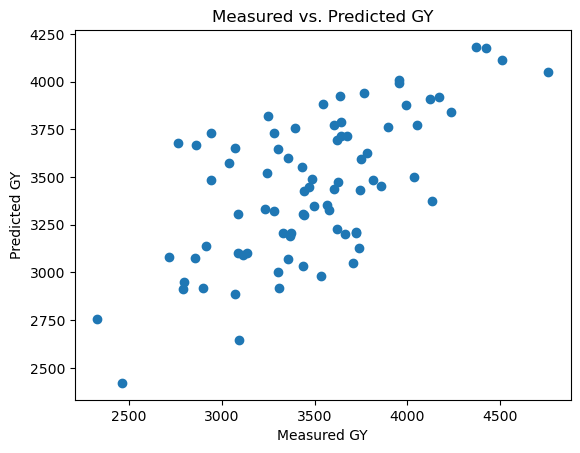

In [ ]:
plt.scatter(x = y_test, y = predictions)

# add achsis labels
plt.xlabel('Measured GY')
plt.ylabel('Predicted GY')
plt.title('Measured vs. Predicted GY')

However, looking at individual data points, it is too difficult to grasp the quality of our predictor. Event if we look at the residuals (the differences between predicted and true values), we still can't really assses our model.

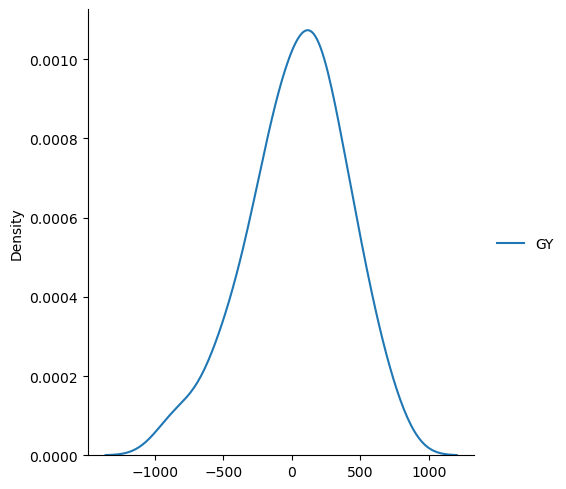

In [43]:
sns.displot((y_test - predictions), kind='kde')

### Regression Evaluation Metrics


The three common evaluation metrics for regression problems are :

**Mean Absolute Error** (MAE) is the mean of the absolute value of the errors:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

**Mean Squared Error** (MSE) is the mean of the squared errors:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

**Root Mean Squared Error** (RMSE) is the square root of the mean of the squared errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

Comparing these metrics:

- **MAE** is the easiest to understand, because it's the average error.
- **MSE** is more popular than MAE, because MSE "punishes" larger errors, which tends to be useful in the real world.
- **RMSE** is even more popular than MSE, because RMSE is interpretable in the "y" units.

All of these are **loss functions**, because we want to minimize them.

In [49]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 286.883867501548
MSE: 127504.33924986697
RMSE: 357.0774975406137


## Optimize model

Having established a baseline model with all features, we can check if we can create a better model if some of "spurious" features are dropped from the dataset. This can be done by forward, backward or mixed feature selection. Here, we apply the backward method, starting from the full model and recursively dropping features.

In [53]:
# Create a linear regression model
model = LinearRegression()

# Create the RFE model and select the top n features
rfe = RFE(model) # Adjust n_features_to_select as needed
fit = rfe.fit(X_train, y_train)


# Get the selected features
selected_features = X.columns[fit.support_]

print(f"Selected features: {selected_features}")



Selected features: Index(['Cultivar_74K75RSF CE', 'Cultivar_77HO111I2X - GUAPORÉ',
       'Cultivar_79I81RSF IPRO', 'Cultivar_82HO111 IPRO - HO COXIM IPRO',
       'Cultivar_82I78RSF IPRO', 'Cultivar_83IX84RSF I2X',
       'Cultivar_96R29 IPRO', 'Cultivar_98R30 CE',
       'Cultivar_ADAPTA LTT 8402 IPRO', 'Cultivar_BRASMAX OLIMPO IPRO',
       'Cultivar_EXPANDE LTT 8301 IPRO', 'Cultivar_FORTALECE L090183 RR',
       'Cultivar_FORTALEZA IPRO', 'Cultivar_FTR 3179 IPRO',
       'Cultivar_FTR 3190 IPRO', 'Cultivar_FTR 4288 IPRO',
       'Cultivar_GNS7900 IPRO - AMPLA', 'Cultivar_MONSOY 8330I2X',
       'Cultivar_MONSOY M8606I2X', 'Cultivar_NK 7777 IPRO',
       'Cultivar_NK 8770 IPRO', 'Cultivar_PAULA IPRO', 'Cultivar_SUZY IPRO',
       'Cultivar_TMG 22X83I2X'],
      dtype='object')


In [54]:
predictions_rfe = rfe.predict(X_test)
predictions_rfe[:10]

array([[3186.55789474],
       [3186.55789474],
       [3186.55789474],
       [3740.2       ],
       [3186.55789474],
       [3878.        ],
       [3687.4       ],
       [3186.55789474],
       [3186.55789474],
       [3186.55789474]])

In [55]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions_rfe))
print('MSE:', metrics.mean_squared_error(y_test, predictions_rfe))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions_rfe)))

MAE: 342.54328947368396
MSE: 174909.1355954265
RMSE: 418.221395430012


This backward selection approach has not helped us so far. Our model is even worse than the full model. We can try to improve it by applying a regularization method, which penalizes the model for having too many features. This is done by adding a penalty term to the loss function. The two most common regularization methods are Lasso and Ridge regression. Before delving deeper, let's first use another python package to run backward selection. statsmodels provides **more statistics** than sklearn. We will use the same dataset as before, but we will need to add a column for the intercept estimation.

### Alternative modeling approach with statsmodels package

In [ ]:
X_train_sm = sm.add_constant(X_train) # Add a constant term for the intercept
model = sm.OLS(y_train, X_train_sm).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     GY   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                     6.319
Date:                Sat, 17 May 2025   Prob (F-statistic):           1.10e-20
Time:                        19:48:21   Log-Likelihood:                -1724.3
No. Observations:                 240   AIC:                             3547.
Df Residuals:                     191   BIC:                             3717.
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

### OLS Regression Output Explained

#### **Model Summary**

| Metric | Value | Description |
|--------|-------|-------------|
| **Dep. Variable** | `GY` | The dependent variable being predicted. |
| **Model** | `OLS` | Ordinary Least Squares regression. |
| **Method** | `Least Squares` | Estimation method used. |
| **No. Observations** | `240` | Number of data points used in the regression. |
| **Df Model** | `48` | Number of independent variables (predictors). |
| **Df Residuals** | `191` | Degrees of freedom left after fitting the model (240 - 48 - 1). |
| **R-squared** | `0.614` | About 61.4% of the variance in `GY` is explained by the model. |
| **Adj. R-squared** | `0.517` | Adjusted for the number of predictors; penalizes overfitting. |
| **F-statistic** | `6.319` | Tests if the overall regression model is statistically significant. |
| **Prob (F-statistic)** | `1.10e-20` | Very small p-value → strong evidence that the model is significant. |
| **Log-Likelihood** | `-1724.3` | Used for model comparison; higher is better. |
| **AIC / BIC** | `3547 / 3717` | Model selection criteria; lower values indicate better fit. |


#### Interpretation:
- **Intercept (`const`)**: When all predictors are zero, the expected value of `GY` is approximately **1429.64**. This is statistically significant (p = 0.018), meaning it's unlikely to be zero by chance.
- **Season**: The coefficient is **21.09**, suggesting a small positive effect on `GY`, but it is **not statistically significant** (p = 0.799). The wide confidence interval also includes zero, indicating uncertainty about the effect.


#### Key Takeaways:
- The model explains a **moderate amount of variance** in the dependent variable (`R² = 0.614`).
- The overall model is **statistically significant** (very low p-value for F-statistic).
- However, **not all individual predictors** (like `Season`) are significant.
- The **adjusted R²** is lower than R², suggesting that some predictors may not be contributing meaningfully and could be overfitting the model.


In [ ]:
# implement backward feature seelction in sm 
def backward_elimination(X, y, significance_level=0.05):
    X = sm.add_constant(X) # add intercept
    while True:
        model = sm.OLS(y, X).fit()
        p_values = model.pvalues.iloc[1:] # exclude intercept
        max_p = p_values.max()
        if max_p > significance_level:
            excluded_feature = p_values.idxmax()
            X = X.drop(columns=[excluded_feature])
        else: 
            break
    return model, X


model_backward_sm, X_train_reduced = backward_elimination(X_train, y_train)
print(model_backward_sm.summary())


                            OLS Regression Results                            
Dep. Variable:                     GY   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                     12.27
Date:                Sat, 17 May 2025   Prob (F-statistic):           5.72e-28
Time:                        20:05:36   Log-Likelihood:                -1738.2
No. Observations:                 240   AIC:                             3524.
Df Residuals:                     216   BIC:                             3608.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

### Comparison of Two OLS Regression Models

#### Model Overview

| Metric | Model 1 | Model 2 |
|--------|---------|---------|
| **R-squared** | 0.614 | 0.566 |
| **Adj. R-squared** | 0.517 | 0.520 |
| **F-statistic** | 6.319 | 12.27 |
| **Prob (F-statistic)** | 1.10e-20 | 5.72e-28 |
| **Log-Likelihood** | -1724.3 | -1738.2 |
| **AIC** | 3547 | 3524 |
| **BIC** | 3717 | 3608 |
| **Observations** | 240 | 240 |
| **Df Model** | 48 | 23 |
| **Df Residuals** | 191 | 216 |



### Interpretation

#### **Model 1**
- **Higher R-squared (0.614)**: Explains more variance in the dependent variable `GY`.
- **Lower Adjusted R-squared (0.517)**: Suggests that the additional predictors may not be contributing meaningfully and could be overfitting.
- **More predictors (48)**: This model is more complex and may be harder to interpret or generalize.

#### **Model 2**
- **Slightly lower R-squared (0.566)**: Explains less variance overall.
- **Higher Adjusted R-squared (0.520)**: Indicates better model efficiency relative to the number of predictors.
- **Fewer predictors (23)**: Simpler model, potentially more robust and interpretable.
- **Better AIC and BIC**: Lower values suggest a better trade-off between model fit and complexity.





In [91]:

# Use only the selected features from training
X_test_reduced = X_test[X_train_reduced.columns.drop('const', errors='ignore')]

# Add constant to match training input
X_test_sm = sm.add_constant(X_test_reduced)

# Predict
y_pred = model_backward_sm.predict(X_test_sm)
residuals = y_test['GY'] - y_pred
print('MAE:', np.mean(np.abs(residuals)) )
print('MSE:', model_backward_sm.mse_resid )
print('RMSE:', np.sqrt(model_backward_sm.mse_resid ))

MAE: 325.9766892009632
MSE: 127057.1088832344
RMSE: 356.4507103138306


### Conclusion

The backward feature selection has not really advanced the model w.r.t the quality of our predictions. From the model.summary() we can see that the most important factors, contributing significantly to yield in soybeans, was  IFP (insertion of the first pod), and, as expected, the cultivar, with Cultivar_MONSOY 8330I2X and Cultivar_FORTALEZA IPRO, being the most productive. We can verify it by looking at GY by cultivar:


- **Model 1** fits the data slightly better in terms of raw R-squared but may be overfitting due to the large number of predictors.
- **Model 2** is more parsimonious, with a better adjusted R-squared and lower AIC/BIC, indicating a more efficient and potentially more generalizable model.

**Recommendation**: If interpretability and generalization are priorities, Model 2 is likely the better choice. If maximizing explained variance is the goal and overfitting is not a concern, Model 1 may be preferred.

## Yet open questions:

Are there any interactions between the features? For example, does the effect of IFP on yield depend on the cultivar? This can be tested with a mixed model approach, where we include interaction effects. We can also check if there are any non-linear relationships between the features and the yield. For example, does the effect of IFP on yield increase or decrease with increasing IFP? This can be tested with polynomial regression or splines.